In [158]:
import math
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext
import matplotlib.pyplot as plt
from torchinfo import summary
from torchmetrics.regression import MeanSquaredError
%matplotlib inline


In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = get_tokenizer("basic_english")
class EEPD_Dataset(Dataset):
    def __init__(self):
        
        data = 'data/WASSA23_conv_level_with_labels_train.tsv'

        xy = pd.read_table(data, header=0)
        new_col = []
        for names in xy.columns:
            new_col.append(names.strip())
        xy.columns = new_col
        x, y = xy.loc[:, 'text'], xy.loc[:, ['EmotionalPolarity', 'Emotion', 'Empathy']]
        y = np.array(y)


        padd_to_tensor = torchtext.transforms.ToTensor(padding_value=0)
        vocab = build_vocab_from_iterator(self.yield_tokens(x), specials=["<unk>"])
        vocab.set_default_index(vocab["<unk>"])
        train_x, train_y = [], []
        for text, label in zip(x, y):
            x_tokens = vocab(tokenizer(text))
            y_label = np.array(label)
            train_x.append(x_tokens)
            train_y.append(y_label)
        train_x = padd_to_tensor(train_x)
        
        self.text = torch.tensor(train_x, dtype=torch.float32).to(device)
        self.label = torch.tensor(train_y).to(device)
        self.n_samples = x.shape[0]


    def __getitem__(self, index):
        return self.text[index], self.label[index]
    
    def __len__(self):
        return self.n_samples
    
    def yield_tokens(self, text_data):
        for text in text_data:
            yield tokenizer(text)



In [156]:
class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_classes):
        super(DeepNN,self).__init__()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, output_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out


In [157]:
dataset = EEPD_Dataset()
#train, test split
generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(dataset=dataset, lengths=[0.8, 0.2], generator=generator)

learning_rate = 0.01
n_samples = len(train_set)
n_epochs = 32
n_input = len(train_set[0][0])
n_hidden = 100
n_classes = 3
n_batch = 64
n_iterations = math.ceil(n_samples/n_batch)

print(f'n_samples: {n_samples} | n_iterations/batch: {n_iterations}')

train_dataloader = DataLoader(dataset=train_set, batch_size=n_batch, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

data_iter = iter(train_dataloader)

# for i in range(1):
#     feature,label = next(data_iter)
# feature,label

n_samples: 7021 | n_iterations/batch: 110


C:\Users\AttahiruJibril\AppData\Local\Temp\ipykernel_6172\2203063665.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.text = torch.tensor(train_x, dtype=torch.float32).to(device)


Layer (type:depth-idx)                   Param #
DeepNN                                   --
├─ReLU: 1-1                              --
├─Linear: 1-2                            13,400
├─Linear: 1-3                            10,100
├─Linear: 1-4                            303
Total params: 23,803
Trainable params: 23,803
Non-trainable params: 0
epoch: 1/32 | step: 100/110 | loss: 6.3153
epoch: 2/32 | step: 100/110 | loss: 6.3128
epoch: 3/32 | step: 100/110 | loss: 6.2056
epoch: 4/32 | step: 100/110 | loss: 7.2262
epoch: 5/32 | step: 100/110 | loss: 6.6281
epoch: 6/32 | step: 100/110 | loss: 8.4391
epoch: 7/32 | step: 100/110 | loss: 8.6579
epoch: 8/32 | step: 100/110 | loss: 9.1484
epoch: 9/32 | step: 100/110 | loss: 7.2326
epoch: 10/32 | step: 100/110 | loss: 9.1494
epoch: 11/32 | step: 100/110 | loss: 9.1796
epoch: 12/32 | step: 100/110 | loss: 6.9744
epoch: 13/32 | step: 100/110 | loss: 10.6942
epoch: 14/32 | step: 100/110 | loss: 6.6583
epoch: 15/32 | step: 100/110 | loss: 10.3294

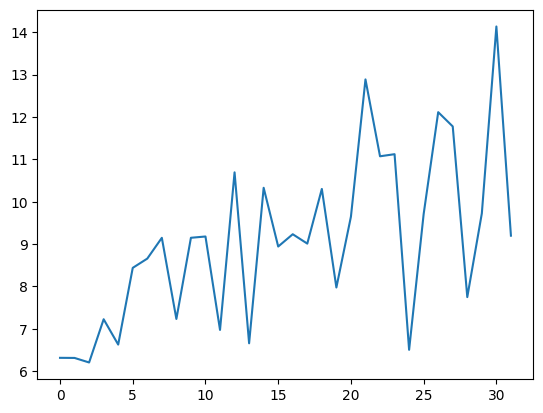

In [200]:
model = DeepNN(n_input, n_hidden, n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
print(summary(model, batch_dim=n_batch))
for epoch in range(n_epochs):
    for i, (input, label) in enumerate(train_dataloader):
        #forward
        output = model(input)
        loss = criterion(output, label)
        
        #backward
        optimizer.zero_grad
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{n_epochs} | step: {i+1}/{n_iterations} | loss: {loss.item():.4f}')
            losses.append(loss)
    
#test
with torch.no_grad():
    error = []
    predictions = []
    for i, (input, label) in enumerate(test_dataloader):
        MSError = MeanSquaredError(num_outputs=3)
        prediction = model(input)
        error.append(MSError(prediction, label))
        predictions.append(prediction)
    # print(f'error: {error}')
    # MSError.plot()
    print(error)
    plt.plot(losses)
    plt.show()

In [185]:
len(test_dataloader)

1755

In [193]:
data_iter = iter(test_dataloader)
for i in range(10):
    feature,label = next(data_iter)
    print(f'label: {label} \t \t prediction: {predictions[i]}')

label: tensor([[1.3333, 1.3333, 1.6667]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[1.6667, 1.3333, 2.6667]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[2.0000, 2.3333, 2.3333]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[1., 2., 2.]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[1.0000, 1.6667, 2.0000]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[0.3333, 1.3333, 1.6667]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[1.6667, 2.6667, 2.3333]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[0.6667, 2.0000, 2.0000]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[2.0000, 2.3333, 3.0000]], dtype=torch.float64) 	 	 predictio